# Variational AutoEncoders

In [1]:
!pip install imageio
!pip install tfp-nightly

     |████████████████████████████████| 4.3MB 2.8MB/s 
     |████████████████████████████████| 296kB 32.4MB/s 


In [2]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import time
import PIL

In [3]:
tf.__version__

'2.2.0'

In [4]:
(train_images, __) , (test_images, __) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [5]:
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1))/255.0
  return np.where(images > 0.5 , 1.0 , 0.0).astype('float32') ## Converting data in bernoulli distribution


In [6]:
train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [7]:
train_size = 60000
batch_size = 32
test_size = 10000

In [8]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images).shuffle(test_size).batch(batch_size))

In [9]:
class Generator(tf.keras.Model):

  def __init__(self, latent_dim, bw=True, depth=32):
    super(Generator, self).__init__()
    self.latent_dim=latent_dim
    self.channel=1 if bw else 3
    self.encoder=tf.keras.Sequential([
                                      tf.keras.layers.InputLayer(input_shape=(26,26,1)),
                                      tf.keras.layers.Conv2D(
                                          filters=32, kernel_size=3, strides=(2,2)
                                      ),
                                      tf.keras.layers.LeakyReLU(),
                                      tf.keras.layers.Dropout(0.3),
                                      tf.keras.layers.Conv2D(
                                          filters=64, kernel_size=3, strides=(2,2)
                                      ),
                                      tf.keras.layers.LeakyReLU(),
                                      tf.keras.layers.Dropout(0.3),                                     
                                      tf.keras.layers.Flatten(),
                                      tf.keras.layers.Dense(latent_dim+latent_dim)

    ])
    
    self.cppn=tf.keras.Sequential([
                                  tf.keras.layers.Dense(units=depth, activation='tanh', input_shape=(latent_dim+3, )),
                                  tf.keras.layers.Dense(units=depth, activation='tanh'),
                                  tf.keras.layers.Dense(units=depth, activation='tanh'),
                                  tf.keras.layers.Dense(1 if bw else 3)
                                  
    ])

    

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)
  
  def coordinates(self, x_dim, y_dim, scale=1.0, batch_size=32):
    n_pixel = x_dim * y_dim
    x_range = scale*(np.arange(x_dim)-(x_dim-1)/2.0)/(x_dim-1)/0.5
    y_range = scale*(np.arange(y_dim)-(y_dim-1)/2.0)/(y_dim-1)/0.5
    x_mat = np.matmul(np.ones((y_dim, 1)), x_range.reshape((1, x_dim)))
    y_mat = np.matmul(y_range.reshape((y_dim, 1)), np.ones((1, x_dim)))
    r_mat = np.sqrt(x_mat*x_mat + y_mat*y_mat)
    x_mat = np.tile(x_mat.flatten(), batch_size).reshape(batch_size, n_pixel, 1).astype('float32')
    y_mat = np.tile(y_mat.flatten(), batch_size).reshape(batch_size, n_pixel, 1).astype('float32')
    r_mat = np.tile(r_mat.flatten(), batch_size).reshape(batch_size, n_pixel, 1).astype('float32')
    return x_mat, y_mat, r_mat

  def create_image(self, x, x_dim, y, y_dim, r, z, batch_size, scale=1.0):
    gen_n_points = x_dim * y_dim
    z_dim=self.latent_dim
    z_scaled = tf.reshape(z, [batch_size, 1, z_dim]) * \
                    tf.ones([gen_n_points, 1], dtype=tf.float32) * scale
    z_unroll = tf.reshape(z_scaled, [batch_size*gen_n_points, z_dim])
    x_unroll = tf.reshape(x, [batch_size*gen_n_points, 1])
    y_unroll = tf.reshape(y, [batch_size*gen_n_points, 1])
    r_unroll = tf.reshape(r, [batch_size*gen_n_points, 1])

    IN=tf.concat([x_unroll, y_unroll, r_unroll, z_unroll], axis=1)
    pred=self.cppn(IN)
    
    result = tf.reshape(pred, [batch_size, y_dim, x_dim, self.channel])

    return result

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar
  
  def reparameterize(self, mean, logvar): ## z=sigma(+)eps + mean
    eps = tf.random.normal(shape=mean.shape)
    return  eps*tf.exp(logvar*.5)+mean


In [10]:
class Discriminator(tf.keras.Model):

  def __init__(self):
    super(Discriminator, self).__init__()
    self.discriminator=tf.keras.Sequential([
                                            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
                                            tf.keras.layers.Conv2D(
                                                filters=64, kernel_size=5, strides=2, padding='same'
                                            ),
                                            tf.keras.layers.LeakyReLU(),
                                            tf.keras.layers.Dropout(0.3),
                                            tf.keras.layers.Conv2D(
                                                filters=128, kernel_size=5, strides=2, padding='same'
                                            ),
                                            tf.keras.layers.LeakyReLU(),
                                            tf.keras.layers.Dropout(0.3),
                                            tf.keras.layers.Flatten(),
                                            tf.keras.layers.Dense(1)

    ])
  @tf.function
  def discriminate(self, input):
    return self.discriminator(input)


In [11]:
def distort_batch(batch):
    batch_size = len(batch)
    row_distort = np.random.randint(0, 3, batch_size)
    col_distort = np.random.randint(0, 3, batch_size)
    result = np.zeros(shape=(batch_size, 26, 26, 1), dtype=np.float32)
    for i in range(batch_size):
      result[i, :, :, :] = batch[i, row_distort[i]:row_distort[i]+26, col_distort[i]:col_distort[i]+26, :]
    return result

In [26]:
optimizer_gen = tf.keras.optimizers.Adam(1e-4)
optimizer_disc = tf.keras.optimizers.Adam(1e-4)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def gen_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

def disc_loss(real_output, fake_output):
  real_loss=cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss=cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss=real_loss+fake_loss
  return total_loss

def reconstruction_loss(actual, reconstructed):
  actual_flatten=tf.reshape(actual, [32, -1])
  recon_flatten=tf.reshape(reconstructed, [32, -1])
  loss=cross_entropy(actual, reconstructed)
  return loss

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def kl_loss(x_logit, x, mean, logvar, z):
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


lambda_vae=1
lambda_gen=0.01

def total_gen_loss(hr, sr, fakes):
  recon_loss=reconstruction_loss(hr, sr)
  generator_loss=gen_loss(fakes)
  lossGen=lambda_gen*generator_loss+lambda_vae*recon_loss
  return lossGen

def total_vae_loss(actual, reconstructed, mean, logvar, z):
  recon_loss=reconstruction_loss(actual, reconstructed)
  latent_loss=kl_loss(reconstructed, actual, mean, logvar, z)
  return 0.5*(recon_loss+latent_loss)

def compute_loss(model_gen, model_disc, x):
  x_26=distort_batch(x)
  mean, log_var=model_gen.encode(x_26)
  z=model_gen.reparameterize(mean, log_var)
  x_c, y_c, r=model_gen.coordinates(x_dim=28, y_dim=28, scale=1.0, batch_size=32)
  images=model_gen.create_image(x_c, 28, y_c, 28, r, z, 32)
  fake_output=model_disc.discriminate(images)
  loss=total_gen_loss(x, images, fake_output)/32.0
  return loss


@tf.function
def train_step(model_gen, model_disc, x, x_26, optimizer_gen , optimizer_disc):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape, tf.GradientTape() as vae_tape:
    ## x we got is of (None, 28, 28, 1)
    mean, log_var=model_gen.encode(x_26)
    z=model_gen.reparameterize(mean, log_var)
    x_c, y_c, r=model_gen.coordinates(x_dim=28, y_dim=28, scale=1.0, batch_size=32)
    images=model_gen.create_image(x_c, 28, y_c, 28, r, z, 32)
    real_output=model_disc.discriminate(x)
    fake_output=model_disc.discriminate(images)
    lossDisc=disc_loss(real_output, fake_output)
    lossGen=gen_loss(fake_output)
    lossVae=total_vae_loss(x, images, mean, log_var, z)
    lossGen=lambda_gen*lossGen+lambda_vae*lossVae

  gradients_gen = gen_tape.gradient(lossGen, model_gen.trainable_variables)
  optimizer_gen.apply_gradients(zip(gradients_gen, model_gen.trainable_variables))

  gradients_disc = disc_tape.gradient(lossDisc, model_disc.trainable_variables)
  optimizer_disc.apply_gradients(zip(gradients_disc, model_disc.trainable_variables))



In [27]:
epochs = 30
latent_dim = 20
num_examples_to_generate = 32

random_vector_for_generation = tf.random.normal( shape=[num_examples_to_generate, latent_dim])
model_gen= Generator(latent_dim)
model_disc=Discriminator()

In [14]:
test_input=train_images[0:32]
test_input=test_input.reshape(32, 28, 28, 1)
print(test_input.shape)

ds_image=distort_batch(test_input)
mean, logvar=model_gen.encode(ds_image)
z = model_gen.reparameterize(mean, logvar)
x, y, r=model_gen.coordinates(28, 28, 1, 32)
images=model_gen.create_image(x, 28, y, 28, r, z,32)
print(images.shape)
res=model_disc.discriminate(images)
print(compute_loss(model_gen, model_disc, test_input))

plt.figure()
plt.imshow(images[0, :, :, 0], cmap='gray')
plt.show()


(32, 28, 28, 1)
(32, 28, 28, 1)
tf.Tensor(0.021900106, shape=(), dtype=float32)


In [15]:
def generate_and_save_images(model_gen, epoch, test_sample):
  batch_size=len(test_sample)
  mean, logvar = model_gen.encode(test_sample)
  z = model_gen.reparameterize(mean, logvar)
  x, y, r=model_gen.coordinates(28, 28, 1, batch_size)
  images=model_gen.create_image(x, 28, y, 28, r, z, batch_size)
  fig=plt.figure(figsize=(8,4))
  for i in range(images.shape[0]):
    plt.subplot(8, 4, i+1)
    plt.imshow(images[i, :, :, 0], cmap='gray')
    plt.axis('off')
  plt.show()


In [16]:
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]
  test_sample=distort_batch(test_sample)


(26, 26, 1)


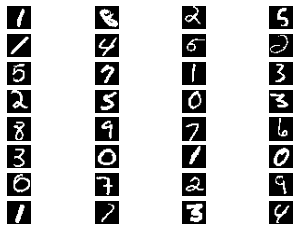

In [17]:
for i in range(test_sample.shape[0]):
    plt.subplot(8, 4, i+1)
    plt.imshow(test_sample[i, :, :, 0], cmap='gray')
    plt.axis('off')

print(test_sample.shape[1:])

Epoch: 30, Loss:, time elapse for current epoch: 56.19726324081421


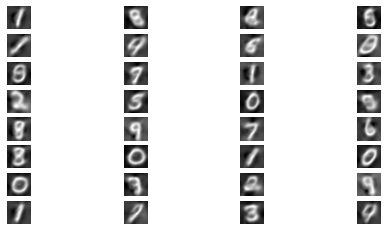

In [28]:
generate_and_save_images(model_gen, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_x_26=distort_batch(train_x)
    train_step(model_gen, model_disc, train_x, train_x_26, optimizer_disc, optimizer_gen)
  end_time = time.time()

  # loss = tf.keras.metrics.Mean()
  # for test_x in test_dataset:
  #   loss(compute_loss(model_gen, model_disc, test_x))
  # elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Loss:, time elapse for current epoch: {}'
        .format(epoch, end_time - start_time))
  generate_and_save_images(model_gen, epoch, test_sample)


(1, 28, 28, 1)
(1, 100, 100, 1)


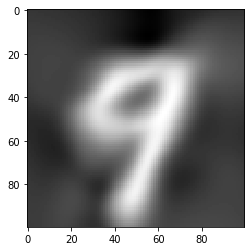

In [42]:
test_input=train_images[45]
test_input=test_input.reshape(1, 28, 28, 1)
print(test_input.shape)

ds_image=distort_batch(test_input)
mean, logvar=model_gen.encode(ds_image)
z = model_gen.reparameterize(mean, logvar)
x, y, r=model_gen.coordinates(100, 100, 1, 1)
images=model_gen.create_image(x, 100, y, 100, r, z,1)
print(images.shape)

plt.figure()
plt.imshow(images[0, :, :, 0], cmap='gray', interpolation='nearest')
plt.show()